In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from rfpimp import *



plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [8]:
columns1 = ["头锥直径", "腔体体积", "放电电容", "出口直径", "最大脱体距离"]
columns2 = ['斜劈角度', '斜劈高', '斜劈宽', '距离', '腔体体积',  '电极间距', '击穿电压', '放电电容', '出口直径','出口倾斜角', '出口侧滑角', '最大激波高度']
# columns2 = ['斜劈角度', '斜劈高', '斜劈宽', '距离', '腔体体积',  '电极间距', '击穿电压', '放电电容', '出口直径','出口倾斜角', '出口侧滑角', '最小斜激波角度']
columns3 = ['斜劈角度', '斜劈高', '斜劈宽', '距离', '腔体体积',  '电极间距', '击穿电压', '放电电容', '出口直径','出口倾斜角', '出口侧滑角', '时刻', '激波高度']



def load_data(filepath):
    """加载数据"""
    with open(filepath) as f:
        data = pd.read_csv(f)
    return data
def save_data(data, savepath):
    np.savetxt(savepath, data, delimiter=",")
    
    
def plot_corr(corr, cols, id):
    """特征相关性热图"""
    plt.figure(figsize=(10,10))
    _ = plt.imshow(corr, cmap=cm.Blues)
    corr = corr.values
    for i in range(corr.shape[0]): # 行
        for j in range(corr.shape[1]): # 列
            text = plt.text(i, j, round(corr[i, j],3),
                           ha="center", va="center", color="black")
    plt.colorbar(_)
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols, rotation=0)
    plt.savefig("./figures/" + str(id) + ".png")
    plt.show()
    
    
def generate_synthetic_data(data_positive, k=2, num=1):
        """
            对于每一个正类样本，产生num个新样本
        :param data_positive: np.ndarray
        :param k:
        :param num:
        :return:
        """
        random.seed(2019) # 设置随机种子
        n, d = data_positive.shape
        data_positive_x = data_positive[:,0:d-1]
        data_positive_y = data_positive[:,d-1][:,np.newaxis]

        final_new_cases = []
        for i, data_x in enumerate(data_positive_x):
            data_y = data_positive_y[i][0]
            index = [j for j in range(data_positive_x.shape[0]) if j != i] # 
            
            data_positive_x_ = data_positive_x[index,:]
            data_positive_y_ = data_positive_y[index,:]
            nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(data_positive_x_)
            distances, indices = nbrs.kneighbors(data_x.reshape(1,-1))
        
            k_neighbors_x = data_positive_x_[indices.ravel(),:]
            k_neighbors_y = data_positive_y_[indices.ravel(),:]
            k_index = [ii for ii in range(k_neighbors_x.shape[0])]
            
            new_cases = []
            for j in range(num): # 产生num个新样本
                ind = random.sample(k_index,1)
                case_x = k_neighbors_x[ind,:].ravel() # 从data的k近邻中随机选择一个样本
                case_y = k_neighbors_y[ind,:].ravel()[0]

                diff_x = data_x - case_x # 因为sb老师不把重复特征样本去掉
                print(diff_x)
                new_x = np.array(data_x + random.random() * diff_x).reshape(1,-1) # 新样本的特征
    
                d1 = np.linalg.norm(new_x-data_x, 2)
                d2 = np.linalg.norm(new_x-case_x, 2)
            
                new_y = np.array([(d2+0.5)/(d1+d2+1) * data_y + (d1+0.5)/(d1+d2+1) * case_y]).reshape(1,-1)
                new_case = np.concatenate((new_x, new_y), axis=1)
                new_cases.append(new_case)
            final_new_cases.append(new_cases)

        # print(final_new_cases)
        # 产生新样本
        new_data = None
        flag = False
        for new_cases in final_new_cases:
            for new_case in new_cases:
                if flag == False:
                    new_data = new_case
                    flag = True
                else:
                    new_data = np.concatenate((new_data, new_case),axis=0)
        return new_data

def plot_feature_importance(feature_dict, model_name):
    """特征重要性
        feature_dict: 字典，键为特证名，值为特征重要性值
        model_name : str, 模型名字，如“ARD”
    """
    sorted_features = sorted(feature_dict.items(), key = lambda item: item[1])
    feature_names = [item[0] for item in sorted_features]
    feature_imp = [item[1] for item in sorted_features]
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(1,1,1)
    ax.barh(np.arange(1, len(feature_names)+1), feature_imp)
    ax.set_yticks(np.arange(1, len(feature_names)+1))
    ax.set_yticklabels(feature_names)
    ax.set_title(model_name)
    ax.set_xlabel("Feature Importance")
#     plt.grid()
    plt.show()

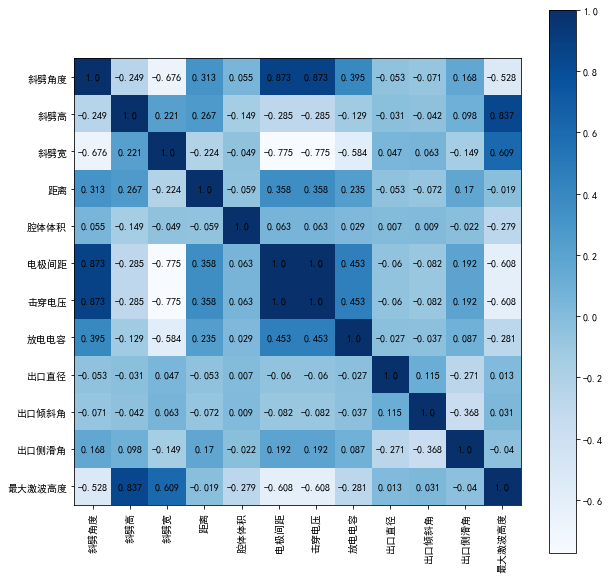

In [9]:
filepath1 = "./头部喷流.csv"
filepath2 = "./横向喷流_最大激波高度.csv"
# filepath2 = "./横向喷流.csv"
filepath3 = "./final_data_hengxiang.csv"
data1 = load_data(filepath1)
data2 = load_data(filepath2)
# data3 = load_data(filepath3)
feature_corr1 = data1.corr()
feature_corr2 = data2.corr()
# feature_corr3 = data3.corr()
# plot_corr(feature_corr1, columns1, 1)
plot_corr(feature_corr2, columns2, 2)
# plot_corr(feature_corr3, columns3, 3)

# 线性回归

In [32]:
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error 
# reg = linear_model.Ridge(alpha=0.2)
# reg.fit(data1[columns1[:4]], data1[columns1[-1]])
# true = list(data1[columns1[-1]])
# pred = reg.predict(data1[columns1[:4]])
# mse = mean_squared_error(true, pred)
# print(mse)


2.9425413230545567


# LASSO

In [10]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
reg = linear_model.Lasso(alpha=0.1)
ss = StandardScaler()
# features = columns2[:11]
features = columns3[:12]
features.remove("电极间距")
# features.remove("斜劈角度")
print(features)
norm_data_X = ss.fit_transform(data3[features])
# data_y = data2[columns2[-1]]
data_y = data3[columns3[-1]]
reg.fit(norm_data_X, data_y)
d = dict(zip(features, abs(reg.coef_)))
plot_feature_importance(d)

['斜劈角度', '斜劈高', '斜劈宽', '距离', '腔体体积', '击穿电压', '放电电容', '出口直径', '出口倾斜角', '出口侧滑角', '时刻']


NameError: name 'data3' is not defined

# 随机森林

['斜劈角度', '斜劈高', '斜劈宽', '距离', '腔体体积', '电极间距', '击穿电压', '放电电容', '出口直径', '出口倾斜角', '出口侧滑角'] 最大激波高度


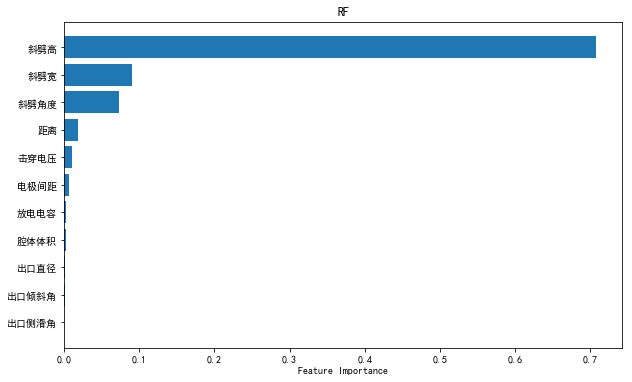

In [76]:
print(columns2[:11], columns2[11])
from sklearn.ensemble import RandomForestRegressor
np.random.seed(4)
regr = RandomForestRegressor(max_depth=3, random_state=2, n_estimators=150, max_features = 8, oob_score= True, bootstrap=True)
regr.fit(data2[columns2[:11]], data2[columns2[11]])

imp = oob_importances(regr, data2[columns2[:11]], data2[columns2[11]], n_samples=data2[columns2[:11]].shape[0])
f_names = list(imp.index)
f_imps = abs(imp.values).ravel()
d = dict(zip(f_names, f_imps))
model_name = "RF"
plot_feature_importance(d, model_name)

# PCA

In [67]:
from sklearn.decomposition import PCA
components = [1,2,3]
white = False
data_y = np.array(data1[columns1[-1]]).reshape(-1,1)
for i in components:
    savepath = "./pca_" + str(i) + ".csv"
    pca = PCA(n_components=i, whiten  = whilte)
    data_X = pca.fit_transform(data1[columns1[:4]])
    data = np.concatenate([data_X, data_y], axis = 1)
#     print(data)
    print(savepath)
    save_data(data, savepath)

./pca_1.csv
./pca_2.csv
./pca_3.csv


# 特征工程

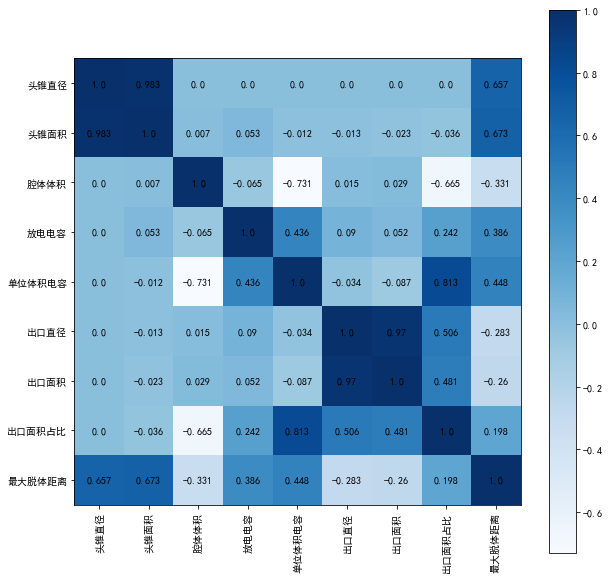

In [78]:
data1["单位体积电容"] = data1["放电电容"] / data1["腔体体积"]
data1["头锥面积"] = data1["头锥直径"] ** 2
data1["出口面积"] = data1["出口直径"] ** 2
data1["出口面积占比"] = data1["出口面积"] / data1["腔体体积"]
col_names = ["头锥直径", "头锥面积", "腔体体积", "放电电容", "单位体积电容", "出口直径", "出口面积", "出口面积占比", "最大脱体距离"]
data1 = data1[col_names]
corrs = data1.corr()
plot_corr(corrs, col_names, 3)

In [91]:
# save_cols = ["头锥直径", "腔体体积", "放电电容", "出口直径", "最大脱体距离"]
save_cols = ['斜劈角度', '斜劈高', '斜劈宽', '腔体体积', '电极间距', '击穿电压', '放电电容', '斜激波尾部最小角度']
data2 = data2[save_cols]
data_X = data2[save_cols[:7]]
data_y = data2[save_cols[7]]
print(data2)
# 对数据进行标准化
ss = StandardScaler()
norm_data_X = ss.fit_transform(data_X)
data_y = data_y.reshape(-1,1)

norm_data = np.concatenate([norm_data_X,data_y], axis = 1)
# print(norm_data)

positive_ids1 = [2, 4] # 值太大的样本
positive_ids2 = [11, 21, 24] # 值太小的样本
ids1 = [True if i in positive_ids1 else False for i in range(norm_data.shape[0])]
ids2 = [True if i in positive_ids2 else False for i in range(norm_data.shape[0])]
data_positive1 = norm_data[positive_ids1, :]
data_positive2 = norm_data[positive_ids2, :]
new_data1 = generate_synthetic_data(data_positive1, k = 1, num = 2)
new_data2 = generate_synthetic_data(data_positive2, k = 2, num = 2)
final_data = np.concatenate([norm_data, new_data1, new_data2], axis= 0)
savepath = "./hengxiang_new_data_all_2.csv"
save_data(final_data, savepath)



    斜劈角度  斜劈高  斜劈宽  腔体体积  电极间距  击穿电压  放电电容  斜激波尾部最小角度
0     60   20   20  1000     7   1.3   640       36.8
1     60   20   20  1000     7   1.3   160       38.4
2     60   20   20  1000     7   1.3   320       40.2
3     60   20   20  1000     7   1.3    80       37.5
4     60   20   20  1000     7   1.3   640       40.8
5     60   20   20  1000     7   1.3   640       36.7
6     60   20   20  1000     7   1.3   640       35.5
7     90   20   15  1000    16   2.8   640       34.7
8     90   20   15  1000    16   2.8   640       33.0
9     90   20   15  1000     7   1.3   640       35.0
10    60   20   15  1000     7   1.3   640       33.8
11    30   20   15  1000     7   1.3   640       28.4
12    90   20   15  1000    16   2.8   640       31.9
13    90   20   15  1000    16   2.8   640       32.8
14    90   20   15  1000    16   2.8   640       31.2
15    90   20   15  1000    16   2.8   640       30.7
16    90   20   15  1000    16   2.8   640       31.1
17    90   20   15  1000    

D:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


# 保存data2特征选择后的结果

In [77]:
# remove_cols = ["距离", "出口直径", "出口侧滑角", "出口倾斜角"]

final_cols = [item for item in columns2 if item not in remove_cols]
new_data = data2[final_cols]
new_data.to_csv("./new_hengxiang_data.csv", index=False)

# 特征重要性

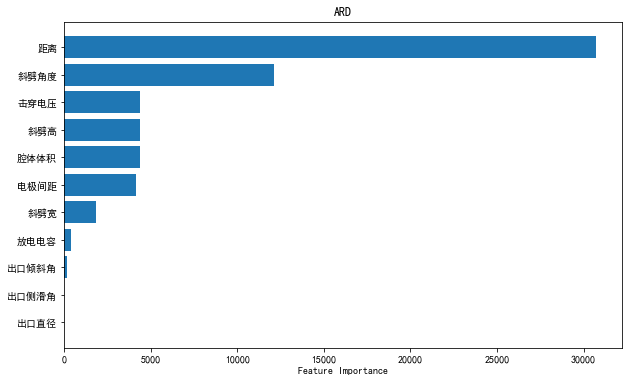

In [3]:
feature_names = ["斜劈角度", "斜劈高", "斜劈宽", "距离", "腔体体积", "电极间距", "击穿电压", "放电电容", "出口直径", "出口倾斜角", "出口侧滑角"]
feature_imp = [1 / i for i in [8.2625e-05, 2.2835e-04, 5.4129e-04, 3.2578e-05, 2.2985e-04, 2.4266e-04, 2.2778e-04, 0.0027, 0.5841, 0.0072, 0.4043]]
d = dict(zip(feature_names, feature_imp))
model_name = "ARD"
plot_feature_importance(d, model_name)

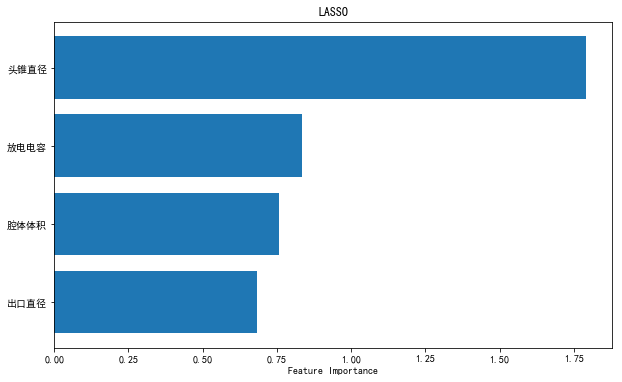

In [21]:
# feature_names = ["斜劈角度", "斜劈高", "斜劈宽", "距离", "腔体体积", "电极间距", "击穿电压", "放电电容", "出口直径", "出口倾斜角", "出口侧滑角"]
# feature_imp = [1 / i for i in [1.5e-3, 3.4777e-5, 1.3527e-5, 0.1665, 1.5809e-4, 2.5065e-5, 2.5295e-5, 0.4564, 0.0410, 0.1514, 0.1828]]

feature_names = ["头锥直径","腔体体积", "放电电容","出口直径"]
feature_imp = [abs(i) for i in [1.7901, -0.7581, 0.8346, 0.6837]]
model_name = "LASSO"
d = dict(zip(feature_names, feature_imp))
plot_feature_importance(d, model_name)